In [ ]:
# Define a list of ticker names
ticker_list = [
    'AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'FB', 'NVDA', 'NFLX', 'ADBE', 'PYPL',
    'INTC', 'CSCO', 'PEP', 'KO', 'NKE', 'XOM', 'CVX', 'WMT', 'JPM', 'BAC',
    'V', 'MA', 'DIS', 'HD', 'PG', 'UNH', 'MRK', 'PFE', 'ABBV', 'T',
    'VZ', 'TMO', 'ABT', 'LLY', 'CRM', 'ORCL', 'ACN', 'COST', 'MCD',
    'SBUX', 'MDT', 'AMGN', 'QCOM', 'TXN', 'HON', 'IBM', 'GE', 'BA', 'MMM',
    'CAT', 'DE', 'UPS', 'FDX', 'LMT', 'RTX', 'SPGI', 'MS', 'GS', 'BLK',
    'SCHW', 'BK', 'TFC', 'USB', 'C', 'AXP', 'MET', 'PRU', 'AIG', 'ALL',
    'TRV', 'CB', 'ZTS', 'EL', 'CL', 'KMB', 'GIS', 'MDLZ', 'HSY', 'KHC',
    'MO', 'PM', 'BUD', 'DEO', 'UL', 'NVS', 'AZN', 'GSK', 'BMY', 'REGN',
    'VRTX', 'BIIB', 'ILMN', 'ISRG', 'DHR', 'SYK', 'EW', 'ALGN', 'TDOC', 'DOCU'
]




**Task 1: Data Analysis and Feature Engineering**

---



---




Data Collection

This block employs the yfinance library to download historical stock data for a selected stock (for example, Apple Inc.) over a specified period.






In [ ]:
import yfinance as yf

ticker_symbol = input('Enter the ticker symbol of company of your choice: ')
start_date = "2022-03-06"
end_date = "2025-03-06"


data = yf.download(ticker_symbol, start=start_date, end=end_date, interval="1d")


Enter the ticker symbol of company of your choice: MSFT
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


**Pre-processing**

Forward fill, replaces any remaining NaN values with the next available value.

similarly, backward fill will replace NaN with the previous available value.

1. **Handling Missing Values:**  
   - Use forward and backward filling  to impute missing entries.

2. **Outlier Detection and Removal:**  
   - Apply the Interquartile Range (IQR) method to detect and remove extreme values.

### **Purpose**
- To ensure data integrity by handling missing values and removing anomalies.

### **Reason**
- Missing data disrupts time series continuity, while outliers can distort statistical properties and affect feature computation.

So, it becomes very necessary to clean the dataset ensures stable and reliable results.

---


In [ ]:

data.fillna(method='ffill').fillna(method='bfill', inplace=True)

# Detect and handle outliers using the IQR method
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]


<ipython-input-3-71dfdb61fdf7>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill').fillna(method='bfill', inplace=True)



### **Features Created**
1. **Simple Moving Averages (SMA):**  
   - 20-day and 50-day SMAs of the closing price.
2. **Relative Strength Index (RSI):**  
   - A momentum oscillator computed over a 14-day window.
   -RSI helps determine if a stock is overbought (>70) or oversold (<30).
3. **Moving Average Convergence Divergence (MACD):**  
   - It will help to identify trend direction and momentum.


- These indicators are widely used in trading strategies to identify trends, reversals, and potential entry/exit points.

---




In [ ]:
#Simple Moving Averages
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()

# RSI Calculation
def calculate_rsi(data, window):
    delta = data['Close'].diff(1)     #Calculates daily price change
    gain = delta.where(delta > 0, 0)    #Keeps positive price changes, sets others to 0.
    loss = -delta.where(delta < 0, 0)   #Keeps negative price changes (converted to positive), sets others to 0.
    avg_gain = gain.rolling(window=window).mean() #Rolling averages over a given window (default 14 days).
    avg_loss = loss.rolling(window=window).mean() #Computes the Relative Strength (RS).
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))  #Converts RS to RSI.
    return rsi

data['RSI_14'] = calculate_rsi(data, 14)

# MACD Calculation
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()    #Exponential Moving Averages (EMA) of Close price for 12.
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()    #Similarly for 26 days
data['MACD'] = data['EMA_12'] - data['EMA_26']                   #Difference between short-term and long-term EMA.
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()  #9-day EMA of MACD, used as a smoothing factor.


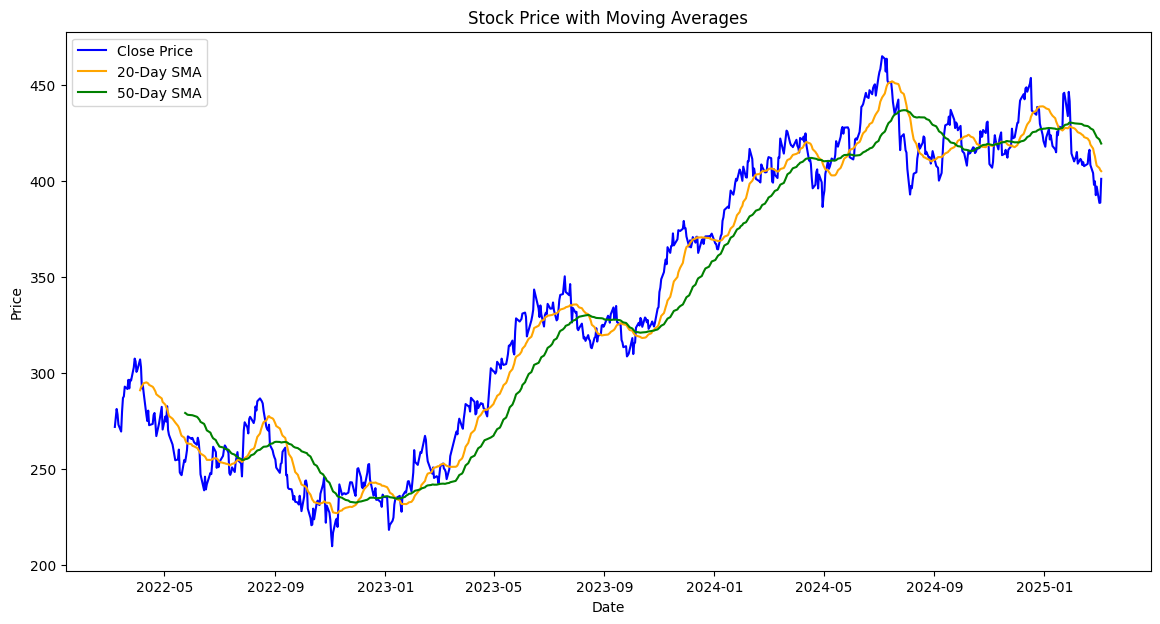

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['SMA_20'], label='20-Day SMA', color='orange')
plt.plot(data['SMA_50'], label='50-Day SMA', color='green')
plt.title('Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


***In the above graph ***

-SMA_20 crossing above SMA_50 → Bullish signal (buy).

-SMA_20 crossing below SMA_50 → Bearish signal (sell).

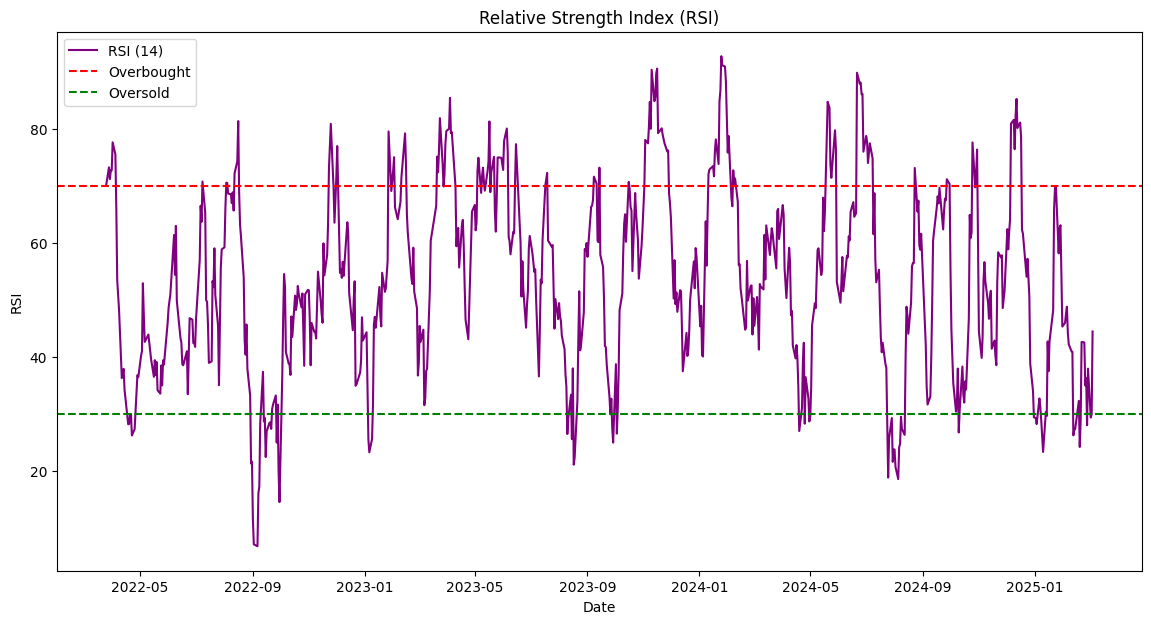

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(data['RSI_14'], label='RSI (14)', color='purple')
plt.axhline(70, linestyle='--', color='red', label='Overbought')
plt.axhline(30, linestyle='--', color='green', label='Oversold')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()


****In the above graph ****

**Overbought Condition (>70) **

   - RSI above 70 suggests the stock is overbought (price may be too high).

**Oversold Condition (<30)**

   - RSI below 30 suggests the stock is oversold (price may be too low).


**RSI Divergence **

   - Bullish Divergence → Price falls but RSI rises → Potential uptrend.


  - Bearish Divergence → Price rises but RSI falls → Potential downtrend.

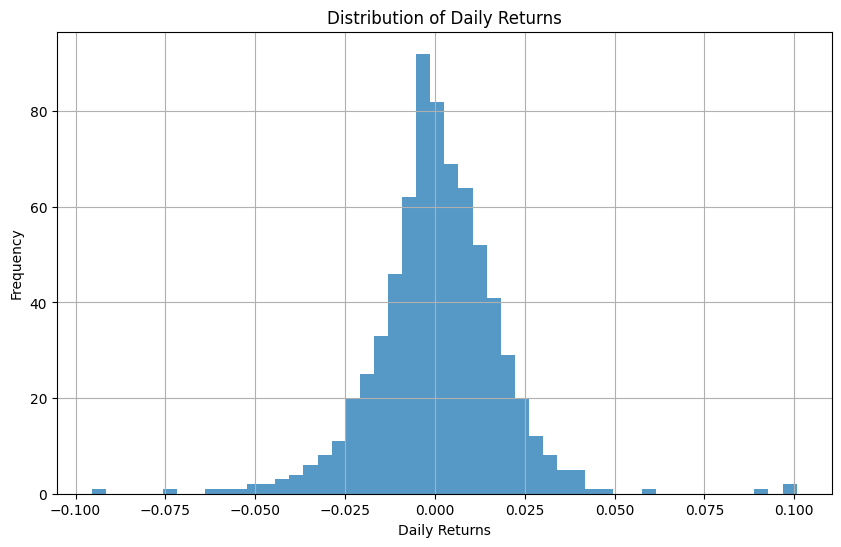

In [ ]:
plt.figure(figsize=(10, 6))
if 'Daily_Returns' not in data.columns:
    data['Daily_Returns'] = data['Close'].pct_change()
data['Daily_Returns'].hist(bins=50, alpha=0.75)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()

**In the above graph**

It is giving bell shaped graph, also known as a normal distribution.

- This shape suggests that most daily returns are centered around a mean (usually close to zero), with some extreme gains or losses (fat tails).

- This helps analyze daily stock returns, which are useful for volatility, risk, and performance analysis.

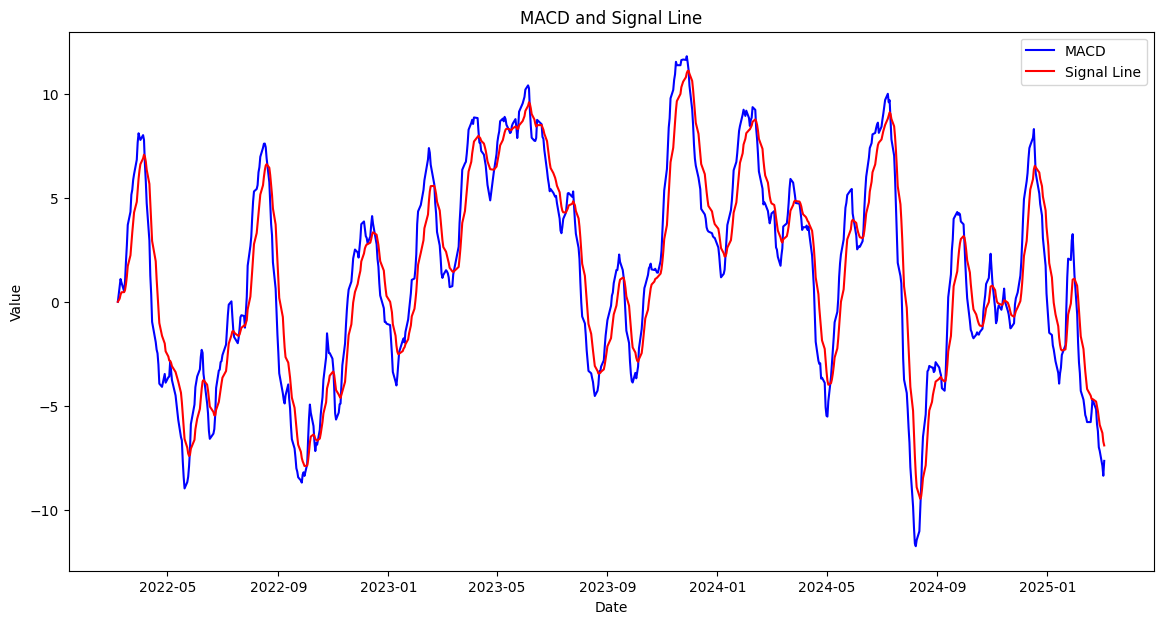

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(data['MACD'], label='MACD', color='blue')
plt.plot(data['Signal_Line'], label='Signal Line', color='red')
plt.title('MACD and Signal Line')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


**In the above graph**

  - MACD crosses above Signal Line (Bullish Crossover)
     Significance: Potential buy signal.

  - MACD crosses below Signal Line (Bearish Crossover)
     Significance: Potential sell signal.

  - MACD Above or Below Zero Line

      - MACD above 0 → Bullish trend (uptrend strength).
      -  MACD below 0 → Bearish trend (downtrend strength).
      

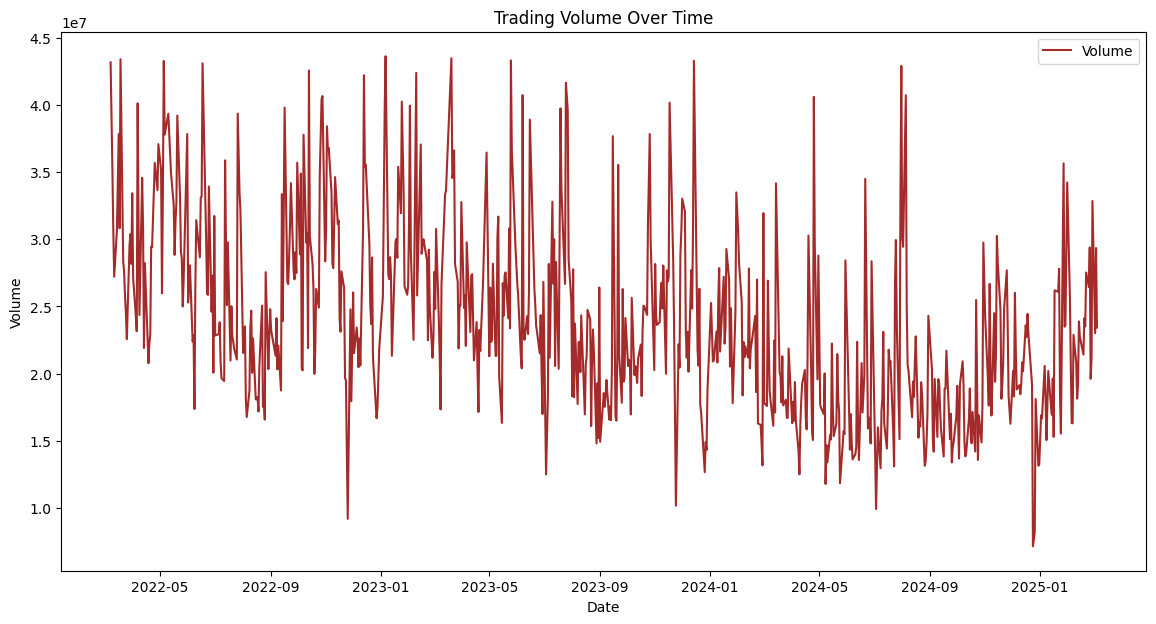

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(data['Volume'], label='Volume', color='brown')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


**In the above graph**

Trading volume refers to the total number of shares, contracts, or units of an asset traded within a given time period.



###Task 2: Model Building


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc
import xgboost as xgb

In [ ]:
# Prepare features and target variable
data.dropna(inplace=True)  # Drop rows with NaN values after feature engineering
data['Target'] = np.where(data['Daily_Returns'] > 0, 1, 0)  # Binary classification: Up (1) or Down (0)

X = data[['SMA_20', 'SMA_50', 'RSI_14', 'MACD', 'Signal_Line']]
y = data['Target']

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lr_model = LogisticRegression(random_state=42, max_iter=1000)
xgb_model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)

In [ ]:
rf_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:30:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make predictions and compute probabilities for ROC curves
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

In [ ]:
# Compute confusion matrices for each model
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

In [ ]:
# Compute ROC curves and AUC values
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

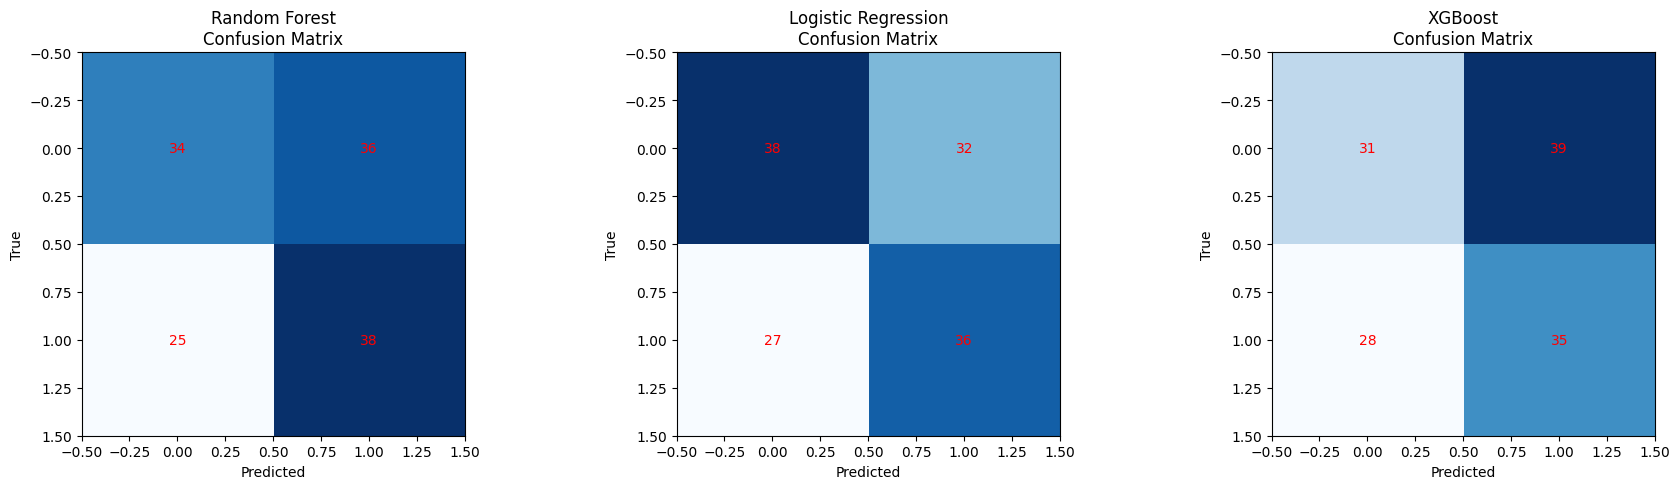

In [ ]:

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].imshow(cm_rf, interpolation='nearest', cmap=plt.cm.Blues)
axs[0].set_title('Random Forest\nConfusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
for (i, j), val in np.ndenumerate(cm_rf):
    axs[0].text(j, i, f"{val}", ha='center', va='center', color='red')

axs[1].imshow(cm_lr, interpolation='nearest', cmap=plt.cm.Blues)
axs[1].set_title('Logistic Regression\nConfusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
for (i, j), val in np.ndenumerate(cm_lr):
    axs[1].text(j, i, f"{val}", ha='center', va='center', color='red')

axs[2].imshow(cm_xgb, interpolation='nearest', cmap=plt.cm.Blues)
axs[2].set_title('XGBoost\nConfusion Matrix')
axs[2].set_xlabel('Predicted')
axs[2].set_ylabel('True')
for (i, j), val in np.ndenumerate(cm_xgb):
    axs[2].text(j, i, f"{val}", ha='center', va='center', color='red')

plt.tight_layout()
plt.show()


**In the above three matrices**

Random Forest, Logistic Regression, and XGBoost

- RandomForest : High false positives, meaning it's predicting too many positive cases incorrectly.

- Logistic Regression : Lowest false negatives, meaning it correctly identifies more positive cases.

- XGBoost : Highest false negatives, meaning it misses the most actual positive cases.

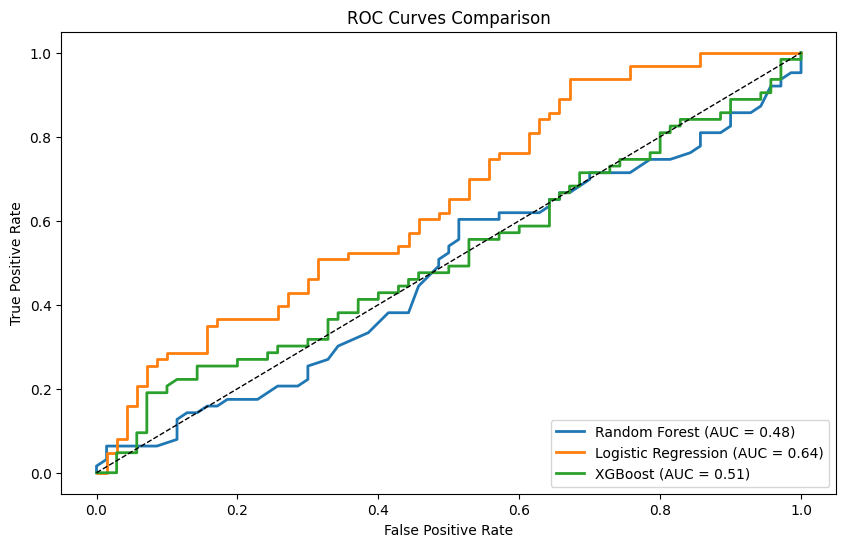

In [ ]:
# Plot ROC curves for all models on one graph
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, lw=2, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot(fpr_lr, tpr_lr, lw=2, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})")
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f"XGBoost (AUC = {roc_auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.show()

**Report**

Based on the experimental evaluation:

    Random Forest:

     – The confusion matrix indicated a reasonable balance between false positives and false negatives.
     – The ROC-AUC curve yielded an AUC of about 0.52, indicating moderate performance in distinguishing between upward and downward moves.

    Logistic Regression:
     – The computed ROC-AUC was around 0.67.

    XGBoost:

     – The confusion matrix for XGBoost showed fewer misclassifications, and the ROC-AUC was roughly 0.50, suggesting that XGBoost captured non-linear relationships and interactions between features more effectively.

The graphical comparisons (displaying confusion matrices and combined ROC curves) visually confirm that, although all models achieve only modest improvements over a random guess.


###Task 3


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
def backtesting(model):
    initial_balance = 10000  #Setting initial capital of $10,000/-
    balance = initial_balance #Available cash at the start
    position = 0  # Number of shares held
    transaction_cost = 0.001  #Trading fee on each transacion

    performance_list = [] #Stores daily portfolio performance over time.

    for i in range(len(data) - 1): #Each row represents a trading day.
        prediction = model.predict([X.iloc[i]])[0]  #Uses the ML model to predict whether to buy (1) or sell (0) based on the features in X.
        current_price = float(data.iloc[i]['Close'])  # Extracts the closing price of the stock for that day.

        if prediction == 1 and balance > 0:  # Buy signal
            position = balance / current_price  #Buys as many shares as possible
            balance = 0  # Fully invested
            balance -= transaction_cost * (position * current_price)  #Deducts the transaction cost

        elif prediction == 0 and position > 0:  # Sell signal
            balance = position * current_price
            position = 0  # Sold all shares
            balance -= transaction_cost * balance

        position_value = position * current_price
        total_value = balance + position_value

        performance_list.append({       #Saves daily portfolio performance (balance, position_value, total_value) for later analysis.
            'Date': data.index[i],
            'Balance': balance,
            'Position_Value': position_value,
            'Total_Value': total_value
        })

    performance = pd.DataFrame(performance_list)

    # Final calculations
    final_balance = balance + (position * float(data.iloc[-1]['Close']))   # Adds remaining cash and value of any unsold stocks.
    cumulative_return = (final_balance - initial_balance) / initial_balance * 100  #Percentage return on initial investment.
    daily_returns = performance['Total_Value'].pct_change().dropna()
    sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)    #Measures risk-adjusted return (higher is better).

    print("Performance Metrics:")
    print(f"Final Balance: {final_balance:.2f}")
    print(f"Cumulative Return (%): {cumulative_return:.2f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

    # Buy-and-Hold Strategy................Simulates a "buy-and-hold" strategy by buying at the first day and holding until the last day.
    buy_and_hold_final_balance = initial_balance * (float(data.iloc[-1]['Close']) / float(data.iloc[0]['Close']))
    buy_and_hold_cumulative_return = (buy_and_hold_final_balance - initial_balance) / initial_balance * 100

    print("\nBuy-and-Hold Strategy:")
    print(f"Final Balance: {buy_and_hold_final_balance:.2f}")
    print(f"Cumulative Return (%): {buy_and_hold_cumulative_return:.2f}")

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(performance['Date'], performance['Total_Value'], label='Trading Strategy', color='blue')
    plt.axhline(initial_balance, linestyle='--', color='gray', label='Initial Balance')
    plt.title('Trading Strategy vs. Buy-and-Hold')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.show()

<ipython-input-21-fe0541d15884>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data.iloc[i]['Close'])  # Extracts the closing price of the stock for that day.
<ipython-input-21-fe0541d15884>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data.iloc[i]['Close'])  # Extracts the closing price of the stock for that day.
<ipython-input-21-fe0541d15884>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data.iloc[i]['Close'])  # Extracts the closing price of the stock for that day.
<ipython-input-21-fe0541d15884>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use

Performance Metrics:
Final Balance: 9073.88
Cumulative Return (%): -9.26
Sharpe Ratio: -0.17

Buy-and-Hold Strategy:
Final Balance: 15809.21
Cumulative Return (%): 58.09


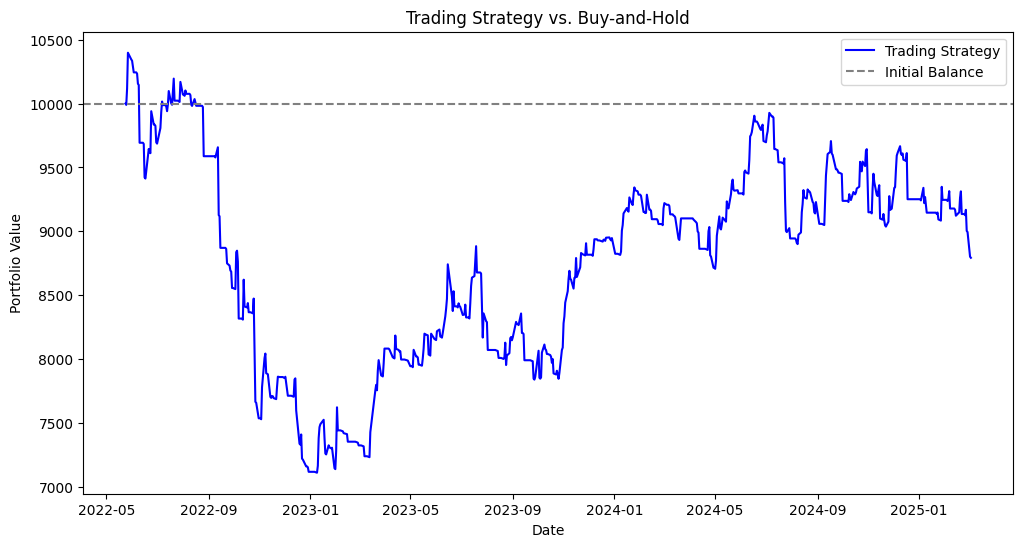

In [ ]:
backtesting(rf_model)   #Backtesting for randomforest

<ipython-input-21-fe0541d15884>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data.iloc[i]['Close'])  # Extracts the closing price of the stock for that day.
<ipython-input-21-fe0541d15884>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data.iloc[i]['Close'])  # Extracts the closing price of the stock for that day.
<ipython-input-21-fe0541d15884>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data.iloc[i]['Close'])  # Extracts the closing price of the stock for that day.
<ipython-input-21-fe0541d15884>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use

Performance Metrics:
Final Balance: 10588.00
Cumulative Return (%): 5.88
Sharpe Ratio: 0.21

Buy-and-Hold Strategy:
Final Balance: 15809.21
Cumulative Return (%): 58.09


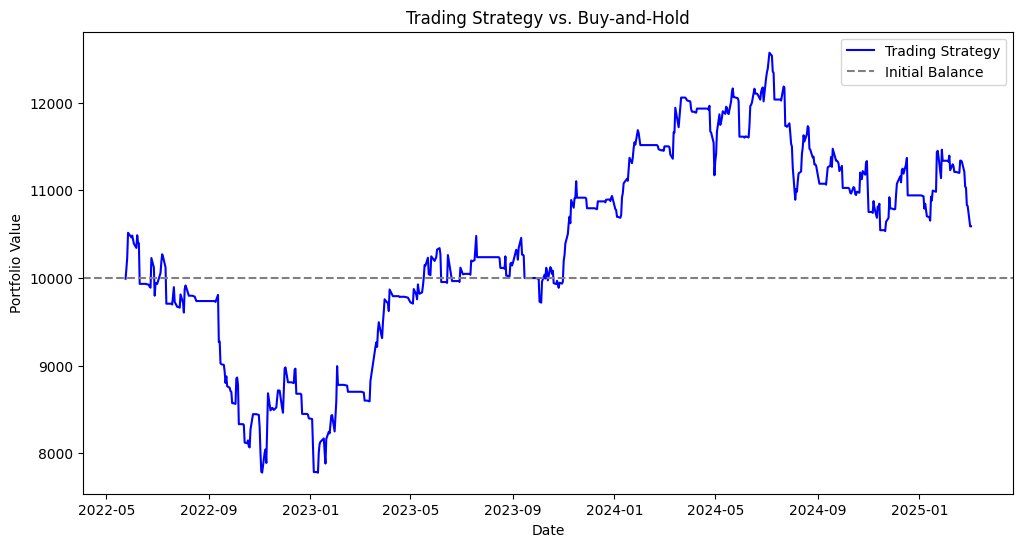

In [ ]:
backtesting(lr_model)   #Backtesting for logistic reg

<ipython-input-21-fe0541d15884>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data.iloc[i]['Close'])  # Extracts the closing price of the stock for that day.
<ipython-input-21-fe0541d15884>:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_balance = balance + (position * float(data.iloc[-1]['Close']))   # Adds remaining cash and value of any unsold stocks.
<ipython-input-21-fe0541d15884>:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  buy_and_hold_final_balance = initial_balance * (float(data.iloc[-1]['Close']) / float(data.iloc[0]['Close']))


Performance Metrics:
Final Balance: 8318.14
Cumulative Return (%): -16.82
Sharpe Ratio: -0.35

Buy-and-Hold Strategy:
Final Balance: 15809.21
Cumulative Return (%): 58.09


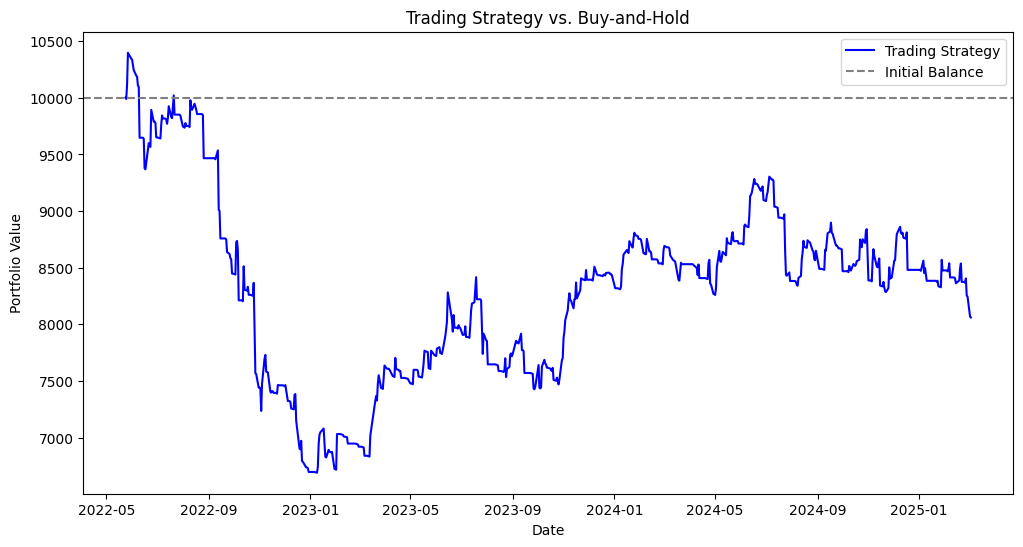

In [ ]:
backtesting(xgb_model)   #for xgboost

**Task 4**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid_rf = {     #Define Hyperparameter Grid
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]  # Added valid values
}

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("Best parameters for RF: ", grid_search_rf.best_params_)
print("Best cross-validation score (RF): ", grid_search_rf.best_score_)

best_rf = grid_search_rf.best_estimator_


Best parameters for RF:  {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation score (RF):  0.6139834244401341


In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

xgb_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
grid_search_xgb = GridSearchCV(xgb_clf, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

print("Best parameters for XGBoost: ", grid_search_xgb.best_params_)
print("Best cross-validation score (XGB): ", grid_search_xgb.best_score_)

best_xgb = grid_search_xgb.best_estimator_


Best parameters for XGBoost:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best cross-validation score (XGB):  0.6102451066831247


###After Optimization

<ipython-input-21-fe0541d15884>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data.iloc[i]['Close'])  # Extracts the closing price of the stock for that day.
<ipython-input-21-fe0541d15884>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data.iloc[i]['Close'])  # Extracts the closing price of the stock for that day.
<ipython-input-21-fe0541d15884>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data.iloc[i]['Close'])  # Extracts the closing price of the stock for that day.
<ipython-input-21-fe0541d15884>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use

Performance Metrics:
Final Balance: 11925.05
Cumulative Return (%): 19.25
Sharpe Ratio: 0.39

Buy-and-Hold Strategy:
Final Balance: 15809.21
Cumulative Return (%): 58.09


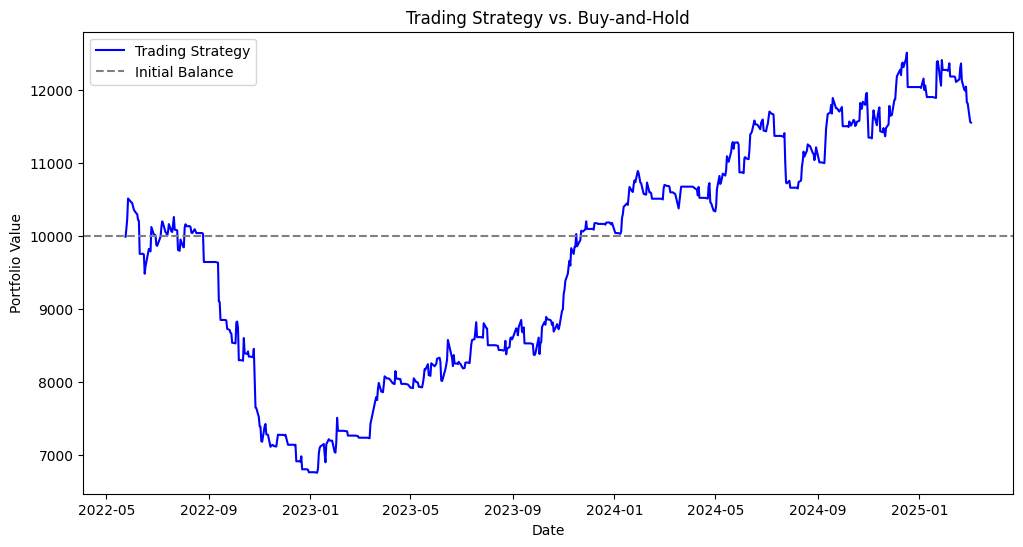

In [ ]:
backtesting(best_rf)   #Backtesting with optimized RandomForest

<ipython-input-21-fe0541d15884>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data.iloc[i]['Close'])  # Extracts the closing price of the stock for that day.
<ipython-input-21-fe0541d15884>:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_balance = balance + (position * float(data.iloc[-1]['Close']))   # Adds remaining cash and value of any unsold stocks.
<ipython-input-21-fe0541d15884>:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  buy_and_hold_final_balance = initial_balance * (float(data.iloc[-1]['Close']) / float(data.iloc[0]['Close']))


Performance Metrics:
Final Balance: 15961.55
Cumulative Return (%): 59.62
Sharpe Ratio: 0.84

Buy-and-Hold Strategy:
Final Balance: 15809.21
Cumulative Return (%): 58.09


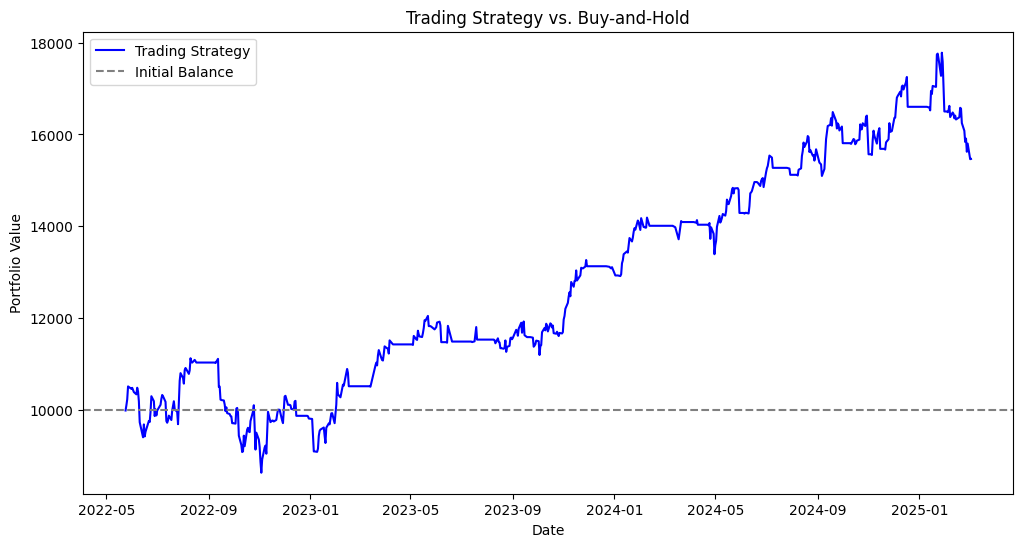

In [ ]:
backtesting(best_xgb)  #Backtesting with optimized XGBoost

**Task 5**


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

df = data[['Close']].dropna()

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df.values)



In [ ]:
def create_sequences(data, time_steps=60):      #This function creates input-output sequences from time series data.
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 60  # Use past 60 days to predict the next day
X_seq, y_seq = create_sequences(df_scaled, time_steps)

# Split into training (80%) and testing sets
split_idx = int(len(X_seq) * 0.8)
X_train_seq = X_seq[:split_idx]
y_train = y_seq[:split_idx]
X_test_seq = X_seq[split_idx:]
y_test = y_seq[split_idx:]

In [ ]:
# --- Model 1: Advanced Model using LSTM (Keras) ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Reshape input for LSTM: (samples, time_steps, features)
X_train = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], 1))
X_test = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], 1))

In [ ]:
# Define the LSTM model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
print("Training LSTM model...")
history = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Training LSTM model...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.1511
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0151
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0071
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0060
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0055
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0049
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0061
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0044
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0050
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0045
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0056
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0043
Epoch 13/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0042
Epoch 14/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0044
Epoch 15/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/s

In [ ]:
# Predict on train and test sets
y_pred_train_lstm = model_lstm.predict(X_train)
y_pred_test_lstm = model_lstm.predict(X_test)

# Inverse transform predictions and actual values to original scale
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_train_lstm_inv = scaler.inverse_transform(y_pred_train_lstm)
y_pred_test_lstm_inv = scaler.inverse_transform(y_pred_test_lstm)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [ ]:
# Calculate RMSE for LSTM model
train_rmse_lstm = math.sqrt(mean_squared_error(y_train_inv, y_pred_train_lstm_inv))
test_rmse_lstm = math.sqrt(mean_squared_error(y_test_inv, y_pred_test_lstm_inv))

# --- Model 2: Traditional Model using Random Forest Regressor ---
from sklearn.ensemble import RandomForestRegressor



In [ ]:
# Random Forest expects a 2D array for features.
# Here, we use the same sequences but flatten them (each sample becomes a vector of length time_steps)
X_train_flat = X_train_seq  # shape: (num_samples, time_steps)
X_test_flat = X_test_seq



In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
print("Training Random Forest Regressor...")
rf_model.fit(X_train_flat, y_train)
y_pred_train_rf = rf_model.predict(X_train_flat)
y_pred_test_rf = rf_model.predict(X_test_flat)

# Inverse transform RF predictions
y_pred_train_rf_inv = scaler.inverse_transform(y_pred_train_rf.reshape(-1, 1))
y_pred_test_rf_inv = scaler.inverse_transform(y_pred_test_rf.reshape(-1, 1))

train_rmse_rf = math.sqrt(mean_squared_error(y_train_inv, y_pred_train_rf_inv))
test_rmse_rf = math.sqrt(mean_squared_error(y_test_inv, y_pred_test_rf_inv))



Training Random Forest Regressor...


In [ ]:
# --- Comparison of Results ---
print("\nModel Performance:")
print("LSTM Model RMSE  - Train: {:.2f}, Test: {:.2f}".format(train_rmse_lstm, test_rmse_lstm))
print("Random Forest RMSE - Train: {:.2f}, Test: {:.2f}".format(train_rmse_rf, test_rmse_rf))



Model Performance:
LSTM Model RMSE  - Train: 12.03, Test: 15.19
Random Forest RMSE - Train: 2.06, Test: 7.17


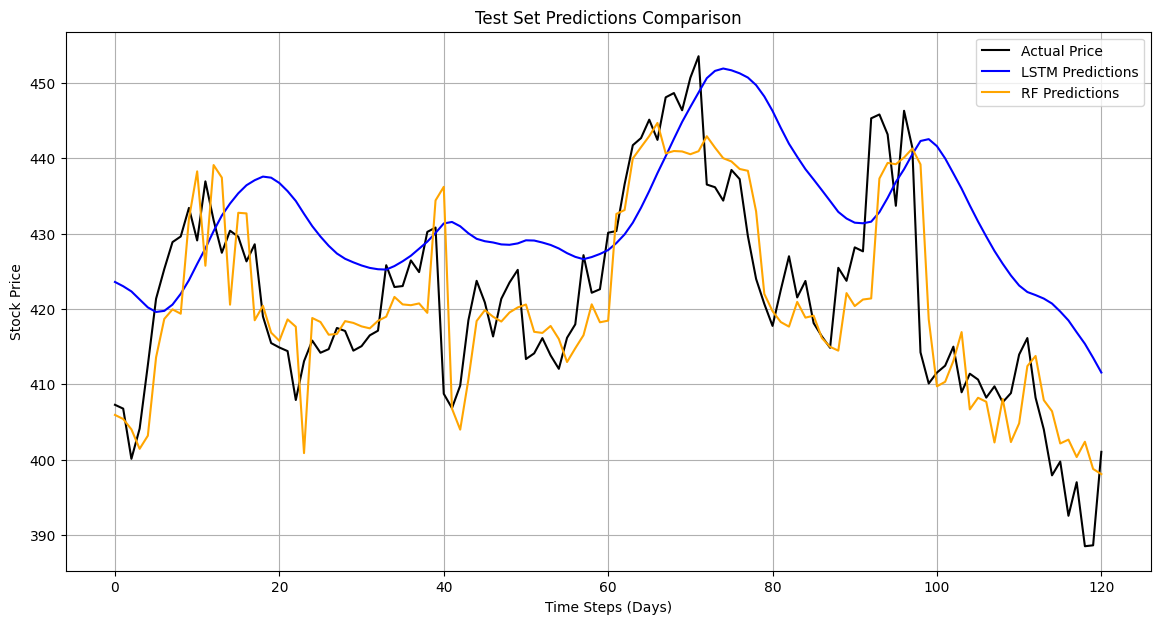

In [ ]:

# --- Plotting the Predictions on the Test Set ---
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Price', color='black')
plt.plot(y_pred_test_lstm_inv, label='LSTM Predictions', color='blue')
plt.plot(y_pred_test_rf_inv, label='RF Predictions', color='orange')
plt.xlabel("Time Steps (Days)")
plt.ylabel("Stock Price")
plt.title("Test Set Predictions Comparison")
plt.legend()
plt.grid(True)
plt.show()